In [90]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


In [91]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if ('cpu'):
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

cuda:0
CUDA is not available.  Training on CPU ...


In [92]:
### Imagenes entre  -1 y 1....luego
#data 2 igual a mi data satelital

## Dataset import

In [107]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from transformsdata import (DualCompose,
                        ImageOnly,
                        Normalize,
                        HorizontalFlip,
                        Rotate,
                        CenterCrop,
                        RandomHueSaturationValue,
                        VerticalFlip)
from torch.utils.data import Dataset
from pathlib import Path
import numpy as np
import cv2
import imageio



batch_size=4


class imagenDataset(Dataset): #leo 1 img, transform, to tensor
    def __init__(self,  img_paths: list,  transform=None, mode= 'train', limit=None):
        self.img_paths =   img_paths
        self.transform = transform
        self.mode= mode
        self.limit = limit
        
    def __len__(self):
        if self.limit is None:
            return len(self.img_paths)
        else:
            return self.limit        #limite????
    
    def __getitem__(self, idx):    
        #cargar una imagen
        if self.limit is None:
            img_file_name = self.img_paths[idx]
            #print('name image in', img_file_name)

        else:
            img_file_name = np.random.choice(self.img_paths)
        
        img = load_image(img_file_name)   #imagen RGB
        #print('one image out', img.shape)
        
        #cargar una mascara
        if self.mode == 'train':
               
            mask = load_mask(img_file_name)   #la mascara
            #print('mask image', img_file_name)
            #print('mask image', mask.shape)
            img, mask = self.transform(img, mask)    #cargo la img y transformo   
            #print(mask.shape)
            return to_float_tensor(img),  torch.from_numpy(np.expand_dims(mask, 0)).float()
            
        else:
            mask = np.zeros(img.shape[:2]) #no se tiene la data =>  zeros
            img, mask = self.transform(img, mask)
            return to_float_tensor(img), str(img_file_name)
            


def load_image(path):
    img = np.load(str(path))
    img=img.transpose((2, 1, 0)) 
    #print('one image in', img.shape)
    return  img # imread read such as BGR  THEN convert to RGB color for matplotlib

def load_mask(path):   
    mask= np.zeros((512, 512))
    mask = np.load(str(path).replace('images', 'masks').replace(r'.npy', r'_a.npy'), 0)
    #print('one mask in ant T', mask.shape)
    mask=mask.transpose(2, 1, 0).reshape(512,-1)
    mask=(mask > 0).astype(np.uint8)
    #print('before the mask',mask.shape)
    return mask#boolean a float    dtype

# swap color axis because
# numpy image: H x W x C
# torch image: C X H X W   

def to_float_tensor(img):#(512, 512, 3)
    #print('img_tensor',img.shape)
    #print('img_tensor-to tensor bedore',img.shape)
    img=torch.from_numpy(img.transpose(2, 1, 0)).float() # torch.Size([3, 512, 512]) convert to tensory change channels
    #print('img_tensor',img.shape) 
    return img 

In [108]:
data_path = Path('data3')
train_path= data_path/'train'/'images'
val_path= data_path/'val'/'images'

train_file_names = np.array(sorted(list(train_path.glob('*.npy'))))
print(len(train_file_names))
val_file_names = np.array(sorted(list(val_path.glob('*.npy'))))
print(len(val_file_names))

113
31


In [109]:
#mask_path=data_path/'train'/'masks'
#train_file_names = np.array(sorted(list(mask_path.glob('*.jpg'))))

#for filename in train_file_names:
    #print((str(filename)))
   # img = cv2.imread(str(filename))
    #print (img.shape)



## Dataloader

In [110]:
def make_loader(file_names, shuffle=False, transform=None, limit=None):
    return DataLoader(
            dataset=imagenDataset(file_names, transform=transform, limit=limit),
            shuffle=shuffle,
            batch_size=batch_size
        )

                      
train_transform = DualCompose([
        CenterCrop(512),
        HorizontalFlip(),
        VerticalFlip(),
        Rotate(),
        ImageOnly(Normalize())
    ])

val_transform = DualCompose([
        CenterCrop(512),
        ImageOnly(Normalize())
    ])

train_loader = make_loader(train_file_names, shuffle=True, transform=train_transform)
#why false shuffle sale error
valid_loader = make_loader(val_file_names, transform=val_transform)
    
    
dataloaders = {
    'train': train_loader, 'val': valid_loader
}

dataloaders_sizes = {
    x: len(dataloaders[x]) for x in dataloaders.keys()
}

dataloaders_sizes 

{'train': 29, 'val': 8}

In [111]:
#img,labels=next(iter(valid_loader)) #tensor Chanelsx HxW #
#print('imgsize',img.shape)
#img = img.transpose((2, 0, 1))  
#img=torch.from_numpy(np.moveaxis(img, -1, 0)).float() #convert to tensor
#print('masksize',lab.shape)

In [112]:
for images, labels in  dataloaders['train']:
    img = images
    lab = labels
#img,labels=next(iter(train_loader)) #tensor Chanelsx HxW 
    #print('imgsize',img.shape)
    #img = img.transpose((2, 0, 1))  
#img=torch.from_numpy(np.moveaxis(img, -1, 0)).float() #convert to tensor

   
    #print('masksize',lab.shape)

torch.Size([4, 4, 512, 512]) torch.Size([4, 1, 512, 512])
-2.117904 23.868757 3.7974317 6.344897
0.0 1.0 0.1775732 0.3821531
(512, 512, 4)


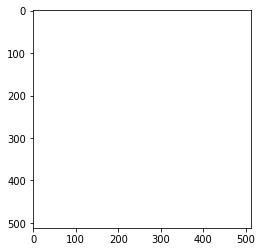

In [120]:
import torchvision.utils
import matplotlib.pyplot as plt

def reverse_transform(inp):   
    inp = inp.numpy().transpose((1, 2, 0))  # chanel 0 sizx 1 sizy 2 => sizx1  sizy2 chanel 0
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))#tensor  CXHXW

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

    
plt.imshow(reverse_transform(inputs[3]))

inp=reverse_transform(inputs[3])
print(inp.shape)


torch.Size([4, 4, 512, 512]) torch.Size([4, 1, 512, 512])
-2.117904 20.78379 8.297445 5.9136715
0.0 1.0 0.120604515 0.32566708
(512, 512, 4)


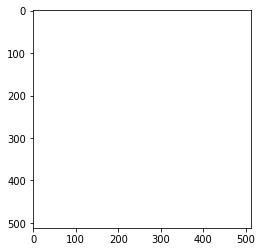

In [122]:
import torchvision.utils
import matplotlib.pyplot as plt

def reverse_transform2(inp): 

#---------------------------------------
    inp = inp.to('cpu').numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.float32)

    return inp
# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))#tensor  CXHXW

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

    
plt.imshow(reverse_transform(inputs[3]))

inp=reverse_transform(inputs[3])
print(inp.shape)

## Model

In [115]:
import os,sys
from torchsummary import summary
import torch
import torch.nn as nn
import pytorch_unet
import models
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = models.UNet11(6)
model = model.to(device)

summary(model, input_size=(3,512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
            Conv2d-2         [-1, 64, 512, 512]           1,792
              ReLU-3         [-1, 64, 512, 512]               0
              ReLU-4         [-1, 64, 512, 512]               0
              ReLU-5         [-1, 64, 512, 512]               0
              ReLU-6         [-1, 64, 512, 512]               0
              ReLU-7         [-1, 64, 512, 512]               0
              ReLU-8         [-1, 64, 512, 512]               0
         MaxPool2d-9         [-1, 64, 256, 256]               0
           Conv2d-10        [-1, 128, 256, 256]          73,856
           Conv2d-11        [-1, 128, 256, 256]          73,856
             ReLU-12        [-1, 128, 256, 256]               0
             ReLU-13        [-1, 128, 256, 256]               0
             ReLU-14        [-1, 128, 2

AttributeError: module 'models' has no attribute 'vgg11_bn'

## Train + metrics

In [131]:
from collections import defaultdict
import torch.nn.functional as F
import loss
from loss import dice_loss, metric_jaccard,metric_dice

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred) #!!!!!
    dice = dice_loss(pred, target)
    
    pred2=(pred >0).float()  #!!!!!!
    dice_m= metric_dice(pred2, target)
    jaccard_m=metric_jaccard(pred2, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)

    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['diceloss'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    metrics['result_jaccard']+= jaccard_m.data.cpu().numpy() * target.size(0)
    metrics['result_dice'] += dice_m.data.cpu().numpy() * target.size(0)
    
    
    return loss

def print_metrics(metrics, epoch_samples, phase): # print by epoch
    outputs = []
    for k in metrics.keys():       #metricas(frist-mean-input.size)samples
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                #print(inputs.shape, labels.shape)
    
    
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics) #criterion

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0) # ctd of samples in a batch

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Train Model

In [133]:
#data me

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import models
#import ternausnet2

#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

#model = models.TernausNetV2(num_classes).to(device)
model = models.UNet11(num_class).to(device)
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1) #25

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=20)

cuda:0
Epoch 0/19
----------
LR 0.0001


/home/jgonzalez/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/jgonzalez/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/jgonzalez/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.619422, diceloss: 0.963673, loss: 0.791547, result_jaccard: 0.052487, result_dice: 0.077324
val: bce: 0.672343, diceloss: 0.797974, loss: 0.735159, result_jaccard: 0.306388, result_dice: 0.407329
saving best model
0m 19s
Epoch 1/19
----------
LR 0.0001
train: bce: 0.192689, diceloss: 0.959830, loss: 0.576259, result_jaccard: 0.053604, result_dice: 0.078591
val: bce: 0.638859, diceloss: 0.805427, loss: 0.722143, result_jaccard: 0.306388, result_dice: 0.407329
saving best model
0m 19s
Epoch 2/19
----------
LR 0.0001
train: bce: 0.171636, diceloss: 0.956730, loss: 0.564183, result_jaccard: 0.052734, result_dice: 0.077610
val: bce: 0.627325, diceloss: 0.757621, loss: 0.692473, result_jaccard: 0.306388, result_dice: 0.407329
saving best model
0m 20s
Epoch 3/19
----------
LR 0.0001
train: bce: 0.156747, diceloss: 0.942444, loss: 0.549595, result_jaccard: 0.053072, result_dice: 0.077768
val: bce: 0.576466, diceloss: 0.721911, loss: 0.649188, result_jaccard: 0.306388, result_dice

# ok

In [125]:
#validationmodel = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=1)

## Save model

In [134]:
torch.save(model.state_dict(),'modelUnet11npy.pth') 

# Prediction

torch.Size([4, 4, 512, 512])
(4, 1, 512, 512)
(4, 512, 512, 3)


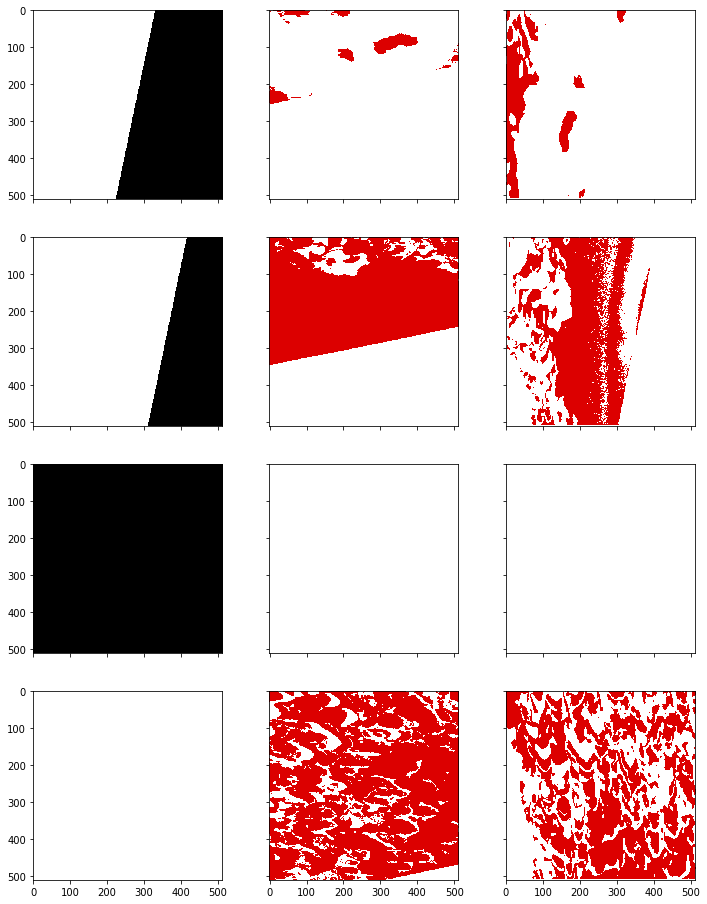

In [155]:
import math
import helper
model.eval()   # Set model to evaluate mode

data_path = Path('data3')
test_path= data_path/'val'/'images' ###cambiar a test3
test_file_names = np.array(sorted(list(test_path.glob('*.npy'))))


test_loader = make_loader(test_file_names, shuffle=True, transform=val_transform)

        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(inputs.shape)
print(pred.shape)
#imshow(inputs[:,:,:3].astype(np.uint8))
# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs[:,:3,:,:].cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]
print(np.shape(input_images_rgb))
helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

### Data medicine

In [17]:

#datta GAb
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import models

#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

model = models.UNet11(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1) #25

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

cuda:0
Epoch 0/39
----------
LR 0.0001


/home/jgonzalez/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


train: bce: 0.159474, dice: 0.364918, loss: 0.262196
val: bce: 0.090030, dice: 0.220920, loss: 0.155475
saving best model
2m 9s
Epoch 1/39
----------
LR 0.0001
train: bce: 0.101003, dice: 0.201541, loss: 0.151272
val: bce: 0.077575, dice: 0.195193, loss: 0.136384
saving best model
2m 10s
Epoch 2/39
----------
LR 0.0001
train: bce: 0.093832, dice: 0.189771, loss: 0.141801
val: bce: 0.069172, dice: 0.152320, loss: 0.110746
saving best model
2m 10s
Epoch 3/39
----------
LR 0.0001
train: bce: 0.088425, dice: 0.170197, loss: 0.129311
val: bce: 0.067093, dice: 0.161246, loss: 0.114170
2m 11s
Epoch 4/39
----------
LR 0.0001
train: bce: 0.078119, dice: 0.159883, loss: 0.119001
val: bce: 0.059565, dice: 0.145185, loss: 0.102375
saving best model
2m 12s
Epoch 5/39
----------
LR 0.0001
train: bce: 0.076694, dice: 0.151089, loss: 0.113892
val: bce: 0.058178, dice: 0.136832, loss: 0.097505
saving best model
2m 11s
Epoch 6/39
----------
LR 0.0001
train: bce: 0.071276, dice: 0.144989, loss: 0.108132


AttributeError: 'UNet11' object has no attribute 'load_state'

### Frist test with data tumor

In [14]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

model = pytorch_unet.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1) #25

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

cuda:0
Epoch 0/39
----------
LR 0.0001


/home/jgonzalez/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.196061, dice: 0.415395, loss: 0.305728
val: bce: 0.133877, dice: 0.245865, loss: 0.189871
saving best model
1m 27s
Epoch 1/39
----------
LR 0.0001
train: bce: 0.115243, dice: 0.238227, loss: 0.176735
val: bce: 0.110779, dice: 0.210341, loss: 0.160560
saving best model
1m 28s
Epoch 2/39
----------
LR 0.0001
train: bce: 0.107966, dice: 0.222649, loss: 0.165307
val: bce: 0.089866, dice: 0.184408, loss: 0.137137
saving best model
1m 28s
Epoch 3/39
----------
LR 0.0001
train: bce: 0.104640, dice: 0.215163, loss: 0.159902
val: bce: 0.096837, dice: 0.177060, loss: 0.136949
saving best model
1m 28s
Epoch 4/39
----------
LR 0.0001
train: bce: 0.098259, dice: 0.204293, loss: 0.151276
val: bce: 0.089363, dice: 0.176605, loss: 0.132984
saving best model
1m 28s
Epoch 5/39
----------
LR 0.0001
train: bce: 0.097415, dice: 0.201191, loss: 0.149303
val: bce: 0.170210, dice: 0.308346, loss: 0.239278
1m 28s
Epoch 6/39
----------
LR 0.0001
train: bce: 0.099143, dice: 0.203391, loss: 0.151267

KeyboardInterrupt: 

# other things

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import models


In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6

model = pytorch_unet.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

In [ ]:
import numpy as np
import cv2
import os
import os.path as osp
from glob import glob
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class imgDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.train = train

        if not self._check_exists():
            raise RuntimeError("Dataset not found.")

        if self.train:
            self.image_names = os.listdir(osp.join(self.root_dir, "train"))
            self.train_data = []
            self.train_labels = []

            for image_name in tqdm(self.image_names):
                train_img = cv2.imread(osp.join(self.root_dir, "train", image_name, "images", image_name + ".jpg"))

                self.train_data.append(train_img)

                target_img = np.zeros(train_img.shape[:2], dtype=np.uint8)
                for target in glob(osp.join(self.root_dir, "train", image_name, "masks", "*.jpg")):
                    target_img_ = cv2.imread(target, 0)
                    target_img = np.maximum(target_img, target_img_)

                self.train_labels.append(target_img)
        else:
            self.image_names = os.listdir(osp.join(self.root_dir, "val"))
            self.test_data = []

            for image_name in tqdm(self.image_names):
                test_img = cv2.imread(osp.join(self.root_dir, "val", image_name, "images", image_name + ".jpg"))

                self.test_data.append(test_img)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, item):
        if self.train:
            image, mask = self.train_data[item], self.train_labels[item]

            if self.transform:
                image = self.transform(image)

            if self.target_transform:
                mask = self.target_transform(mask)

            return image, mask
        else:
            image = self.test_data[item]

            if self.transform:
                image = self.transform(image)

            return image

    def _check_exists(self):
        return osp.exists(osp.join(self.root_dir, "train")) and osp.exists(osp.join(self.root_dir, "val"))


class Rescale:
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        return cv2.resize(image, (self.output_size, self.output_size), cv2.INTER_AREA)


class Normalize:
    def __call__(self, image):
        image = image.astype(np.float32) / 255
        return image


class ToTensor:
    def __call__(self, data):
        if len(data.shape) == 2:
            data = np.expand_dims(data, axis=0)
        elif len(data.shape) == 3:
            data = data.transpose((2, 0, 1))
        else:
            print("Unsupported shape!")
        return torch.from_numpy(data)



Img_dataset =imgDataset(root_dir="data",
                                     train=True,
                                     transform=transforms.Compose([Rescale(512)]),
                                     target_transform=transforms.Compose([Rescale(512)]))

for i in range(len(Img_dataset)):
        image, mask = Img_dataset[i]

        print(i, image.shape, mask.shape)
        cv2.imshow('image', image)
        cv2.imshow('mask', mask)

        if i == 5:
            break

# no funcion

In [ ]:
import torch
import train
from torch import nn

from pathlib import Path
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose

In [6]:
!python train.py --device-ids 0 --fold 1 --limit 100 --batch-size 4 --n-epochs 100 --model UNet


num train = 316, num_val = 79
Epoch 1, lr 0.0001:   0%|                               | 0/100 [00:00<?, ?it/s]Traceback (most recent call last):
  File "train.py", line 117, in <module>
    main()
  File "train.py", line 112, in main
    fold=args.fold
  File "/home/jgonzalez/Anaconda/Test_network1/red_test1/utils.py", line 66, in train
    for i, (inputs, targets) in enumerate(tl):
  File "/home/jgonzalez/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 637, in __next__
    return self._process_next_batch(batch)
  File "/home/jgonzalez/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 658, in _process_next_batch
    raise batch.exc_type(batch.exc_msg)
RuntimeError: Traceback (most recent call last):
  File "/home/jgonzalez/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])


In [7]:
%matplotlib inline
import cv2
from pylab import *

In [8]:
rcParams['figure.figsize'] = 256, 256

In [9]:
import torch

from torch import nn
from unet_models import unet11
from pathlib import Path
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose

In [10]:
 device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#xxx device = torch.device('cuda:0')
#ffdevice = torch.device('cpu')

In [11]:
def get_model():
    model = unet11(pretrained='False')
    model.eval()
    return model.to(device)

In [12]:
def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [13]:
def load_image(path, pad=True):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (newtwork requirement)
    
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if not pad:
        return img
    
    height, width, _ = img.shape
    
    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
        
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
    
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)

    return img, (x_min_pad, y_min_pad, x_max_pad, y_max_pad)

In [14]:
img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
def crop_image(img, pads):
    """
    img: numpy array of the shape (height, width)
    pads: (x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    
    @return padded image
    """
    (x_min_pad, y_min_pad, x_max_pad, y_max_pad) = pads
    height, width = img.shape[:2] 
    
    return img[y_min_pad:height - y_max_pad, x_min_pad:width - x_max_pad]
    

In [16]:
model = get_model()

# Example on dataset 

In [22]:
img, pads = load_image('data/train/angyodysplasia/images/113.jpg', pad=True)  #como uso path jala desde home hasta red_test1

In [23]:
imshow(img)

In [24]:
with torch.no_grad():
    input_img = torch.unsqueeze(img_transform(img).to(device), dim=0)

In [25]:
with torch.no_grad():
    mask = F.sigmoid(model(input_img))

/home/jgonzalez/miniconda3/envs/pytorch_env/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [26]:
mask_array = mask.data[0].cpu().numpy()[0]

In [27]:
mask_array = crop_image(mask_array, pads)

In [28]:
imshow(mask_array)

In [29]:
imshow(mask_overlay(crop_image(img, pads), (mask_array > 0.5).astype(np.uint8)))

In [1]:
#Train the network


In [ ]:
#https://github.com/topics/unet-image-segmentation?o=asc&s=forks   unet geo